In [ ]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
#import seaborn as sns

In [ ]:
from random import random
from tqdm.notebook import tqdm

In [ ]:
import time
import multiprocess as mp

### Read data & preprocessing

In [ ]:
df_ref = pd.read_csv('./Data/glioblastoma_BT_S2/ref.csv', index_col = 0)
df_alt = pd.read_csv('./Data/glioblastoma_BT_S2/alt.csv', index_col = 0)

In [ ]:
# use multi-index for easier handling of the data
df_ref['chromosome'] = [locus.split('_')[0] for locus in df_ref.index]
df_ref['locus'] = [locus.split('_')[1] for locus in df_ref.index]
df_ref = df_ref.set_index(['chromosome', 'locus'])

df_alt['chromosome'] = [locus.split('_')[0] for locus in df_alt.index]
df_alt['locus'] = [locus.split('_')[1] for locus in df_alt.index]
df_alt = df_alt.set_index(['chromosome', 'locus'])

### Mutation detection

In [ ]:
from mutation_detection import *
from LOH_detection import *

In [ ]:
ref = df_ref.to_numpy(dtype = float)
alt = df_alt.to_numpy(dtype = float)
coverages = ref.flatten() + alt.flatten()

In [ ]:
ref.shape

In [ ]:
(1 - 1/(2*1168 - 2)**2) ** 16153

In [ ]:
get_composition_priors(10, genotype_freq = {'R': 1/3, 'H': 1/3, 'A': 1/3}, mutation_rate = 0.25)

In [ ]:
start_time = time.time()
posteriors = get_posteriors(ref, alt, n_threads = 6)
print('Runtime:', (time.time() - start_time) / 60, 'min')
pd.DataFrame(posteriors, columns = ['R', 'H', 'A', 'RH', 'HA'], index = df_ref.index).to_csv('./posteriors.csv')

In [ ]:
df_posteriors = pd.read_csv('./posteriors.csv', index_col = (0,1))
posteriors = df_posteriors.to_numpy()

In [ ]:
mutated_idx, mut_type_idx = np.where(posteriors[:,3:] > 1 - 1 / posteriors.shape[0])
n_mutated = mutated_idx.size
homos = [['R', 'A'][i] for i in mut_type_idx]

In [ ]:
corr_posteriors = get_corr_posteriors(ref[mutated_idx,:], alt[mutated_idx,:], homos, corr_prior = 1/2) 

In [ ]:
pd.DataFrame(data = {'correlation posterior': np.concatenate((corr_posteriors, [0])), 'mutation type': ['H' + h for h in homos]}, 
             index = df_posteriors.index[mutated_idx]).to_csv('./corr_posteriors.csv')

### Data Generator

In [1]:
from data_generator import *

In [3]:
dg = DataGenerator(64, 200)

In [4]:
ref, alt = dg.generate_reads()

  0%|          | 0/64 [00:00<?, ?it/s]

In [5]:
likelihoods1, likelihoods2 = get_likelihoods(ref, alt, dg.gt1, dg.gt2)

In [6]:
dg.tree.fit_likelihoods(likelihoods1, likelihoods2)
dg.tree.fit()

In [7]:
dg.tree.likelihood

-17314.134162947557

### Tree Inference Test

In [8]:
from tree import *
from tree_inference import *

In [9]:
ct, mt, likelihood_history, space = optimize_tree(likelihoods1, likelihoods2)

[Cell Tree] Timeout reached.
[Mutation Tree] Converged after 9541 steps
[Cell Tree] Converged after 1060 steps
[Mutation Tree] Converged after 1001 steps
[Cell Tree] Converged after 1588 steps
[Mutation Tree] Converged after 1031 steps
[Cell Tree] Converged after 844 steps
[Mutation Tree] Converged after 2709 steps
[Cell Tree] Converged after 737 steps
[Mutation Tree] Converged after 1413 steps
[Cell Tree] Converged after 934 steps
[Mutation Tree] Converged after 1987 steps
[Cell Tree] Converged after 660 steps
[Mutation Tree] Converged after 1001 steps
[Cell Tree] Converged after 439 steps
[Mutation Tree] Converged after 1001 steps
[Cell Tree] Converged after 417 steps
[Mutation Tree] Converged after 1002 steps
[Cell Tree] Converged after 323 steps
[Mutation Tree] Converged after 1006 steps
[Cell Tree] Converged after 329 steps
[Mutation Tree] Converged after 1022 steps
[Cell Tree] Converged after 320 steps
[Mutation Tree] Converged after 1050 steps
[Cell Tree] Converged after 333 ste

In [10]:
likelihood_history

[-19121.9191899027,
 -19120.55981428237,
 -19117.223942184228,
 -19108.75348980886,
 -19099.883461924277,
 -19072.130760836953,
 -19064.298954730635,
 -19044.439030229845,
 -19036.077545724158,
 -19012.36355067896,
 -19005.84089676395,
 -18998.615056676732,
 -18961.220104788692,
 -18884.036945130003,
 -18869.84560582908,
 -18862.57124429683,
 -18855.664112821887,
 -18853.858315449685,
 -18827.619162807645,
 -18823.67376843705,
 -18800.61101018312,
 -18795.516133748406,
 -18790.469044722668,
 -18788.561061268876,
 -18769.66710575441,
 -18747.8415044831,
 -18743.911037621066,
 -18742.315135711662,
 -18737.837801073703,
 -18736.828652469085,
 -18736.81710849126,
 -18732.82859875505,
 -18726.9027157385,
 -18720.611592002275,
 -18718.03375200411,
 -18717.71158929747,
 -18707.104145292542,
 -18706.391714842168,
 -18689.69849401838,
 -18664.19009166465,
 -18637.34593032456,
 -18596.625049554135,
 -18568.731233687526,
 -18519.70525267933,
 -18518.930619022,
 -18518.17937231491,
 -18491.6228963

In [ ]:
ct = CellTree()
ct.fit(likelihoods1, likelihoods2)

In [30]:
history = ct.hill_climb()
print(history)

[Cell Tree] Converged after 138 steps
[-238.76419535645618, -235.22143096720703, -235.0821862275111, -233.3416557024404, -220.5962063797329, -218.51202780697867]


In [31]:
ct.likelihood

-230.0758738863463

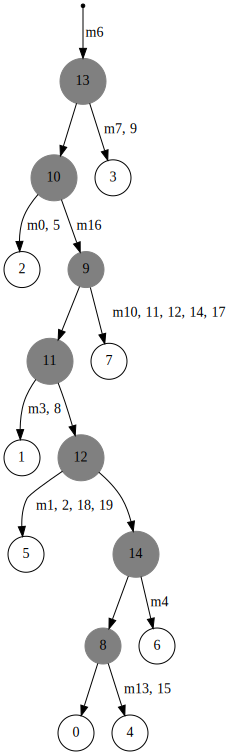

In [21]:
ct.to_graphviz()

In [54]:
ct.likelihood

-4249.528260398164

### Tree Test

In [8]:
from tree import *

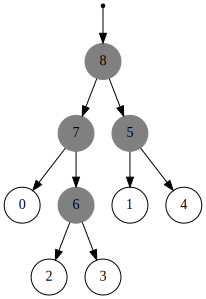

In [14]:
ct = CellTree(5)
ct.to_graphviz()

In [15]:
for node in ct.root.reverse_DFS: 
    print(node.ID)

1
4
5
0
2
3
6
7
8


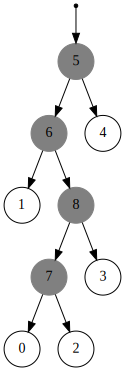

In [14]:
ct.subtree_swap(ct.nodes[1], ct.nodes[4])
ct.to_graphviz()

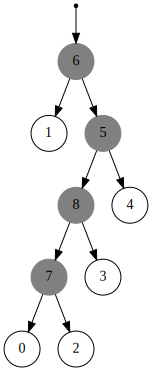

In [15]:
ct.prune_insert(ct.nodes[4], ct.nodes[8])
ct.to_graphviz()

In [4]:
def infer_tree(likelihoods1, likelihoods2): 
    n_cells, n_mut = likelihoods1.shape
    current_tree = CellTree(n_cells, n_mut)
    proposed_tree = CellTree().copy(current_tree)

In [10]:
mt = MutationTree(8)

mt.nodes[1].assign_parent(self.nodes[0])
mt.nodes[2].assign_parent(self.nodes[0])
mt.nodes[3].assign_parent(self.nodes[0])
mt.nodes[4].assign_parent(self.nodes[1])
mt.nodes[5].assign_parent(self.nodes[2])
mt.nodes[6].assign_parent(self.nodes[2])

mt.nodes[1].mutations = [0,1]
mt.nodes[2].mutations = [2]
mt.nodes[3].mutations = [3]
mt.nodes[4].mutations = [4]
mt.nodes[5].mutations = [5]
mt.nodes[6].mutations = [6]

mt.attachments = np.array([1,1,0,5,5,5,3,2], dtype = int)

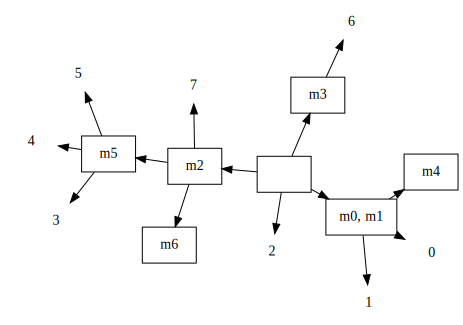

In [11]:
mt.to_graphviz()

### SVD Imputation

In [ ]:
# X: data matrix in which rows (dimension 0) are samples and columns (dimension 1) are features
def mean_impute(X): 
    X_imputed = X.copy() 
    for i in range(X.shape[1]): 
        feature = X[:,i] 
        mean = np.nanmean(feature) # take mean of the feature, ignoring NaN
        if np.isnan(mean): 
            print('[Mean Imputation] WARNING: Empty feature at column %d.'%i) 
        nan_indices = np.where(np.isnan(feature))[0] 
        X_imputed[nan_indices,i] = mean 
    return X_imputed 


def zero_impute(X): 
    X_imputed = X.copy()
    X_imputed[np.isnan(X)] = 0
    return X_imputed
    

def svd_impute(X, rank = None, tol = 0.1, max_iter = 100):
    if rank is None: 
        rank = min(X.shape) // 2
    
    nan_indices = np.where(np.isnan(X))
    X_imputed = zero_impute(X) #initialise all nan entries with the a mean imputation
    
    for i in tqdm(range(max_iter)):
        X_old = X_imputed.copy()
        L,D,R = np.linalg.svd(X_imputed)
        X_approx = L[:,:rank] @ np.diag(D[:rank]) @ R[:rank,:] #rank r approximation of X_imputed
        X_imputed[nan_indices] = X_approx[nan_indices]
        fnorm = np.linalg.norm(X_old - X_imputed, ord="fro")
        if fnorm < tol:
            print('[SVD Imputation]: Converged after %d iterations.'%(i+1))
            print('Frobenius norm:', fnorm)
            break
        if (i+1) >= max_iter:
            print('[SVD Imputation]: Maximum number (%d) of iterations reached.'%(i+1))
            print('Frobenius norm:', fnorm)
    
    return X_imputed

In [ ]:
ref.shape

In [ ]:
np.sum(alt > 5, axis = 1)

In [ ]:
with sns.axes_style("darkgrid"):
    plt.figure(figsize = (16, 12))
    plt.plot(np.sum(alt > 16, axis = 1))
    plt.show()

In [ ]:
for i in range(ref.shape[0]): 
    for j in range(ref.shape[1]): 
        if ref[i,j] == 0 and alt[i,j] == 0:
            ref[i,j] = np.nan
            alt[i,j] = np.nan

In [ ]:
X = np.concatenate([ref, alt], axis = 1)
X_imputed = svd_impute(X, rank = 5)

In [ ]:
X_imputed.shape

In [ ]:
ref_imputed = X_imputed[:,:ref.shape[1]]
alt_imputed = X_imputed[:,ref.shape[1]:]

In [ ]:
ref_proportion = (ref_imputed + 1) / (ref_imputed + alt_imputed + 2)

plt.figure(figsize=(24,16))
plt.imshow(ref_proportion.T, cmap = 'viridis', vmin = 0., vmax = 1.) 
# "viridis": yellow for 1, purple for 0, green/blue for 0.5 (https://matplotlib.org/3.5.1/tutorials/colors/colormaps.html)
plt.xlabel('locus index', fontsize = 17)
plt.ylabel('cell index', fontsize = 17)
plt.show()

### HMM

In [ ]:
# I: initial probability
# T: transition probability (including the begin state)
# E: emission probability
# X: observation
def viterbi(I, T, E, X):
    length = X.shape[0]
    n_states = X.shape[1]
    v = np.zeros((length, n_states)) # v[j, k] = max joint probability having k at step j and emission X[i]
    
    v[0,:] = np.array([I[i] * E(i, X[0]) for i in range(n_states)])
    for j in range(1, length):
        for k in range(n_states):
            v[j,k] = E(k, X[j]) * np.max([v[j-1,l] * T(l,k) for l in range(n_states)]) # l: assumed state of previous step
    
    best_path = np.argmax(v, axis = 1)
    
    return best_path, v[-1, best_path[-1]] # second return is the max joint probability

In [ ]:
transition_matrix = np.array([[0.9, 0.1],
                              [0.5, 0.5]])
def T(pre, post):
    return transition_matrix[pre, post]

In [ ]:
def E(state, obs, f = 0.7, omega = 10):
    n_ref = obs[0]
    coverage = np.sum(obs)
    if state == 1: # normal (heterozygous)
        alpha = (1/2 - 2/3 * f) / omega
        beta = omega - alpha
    elif state == 2: # LOH
        alpha = f * omega
        beta = omega - alpha
    else: 
        print('\n ERROR: invalid state \n')
        return
    
    return betabinom.pmf(n_ref, coverage, alpha, beta)

In [ ]:
X = np.stack((np.array(df_ref.loc['chr1',:])[0,:], np.array(df_alt.loc['chr1',:])[0,:])).T
X